<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0).reset_index(drop=True)

In [3]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# 整理資料

In [4]:
test_200 = test_250.loc[ test_250.index % 5 != 0 ,:]#5不可整除
test_50 = test_250.loc[ test_250.index % 5 == 0 ,:]#5可以整除
train = train.append(test_200)#200筆加入train
print(train.shape)
print(test_170.shape)
print(test_50.shape)

(4721, 27)
(170, 27)
(50, 27)


# def features y_name

In [0]:
features = ['T10','T50','T90','N+A']
y_name = 'C9A'

# features scaler

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train[features])

train[features] = scaler.transform(train[features])
test_170[features] = scaler.transform(test_170[features])
test_50[features] = scaler.transform(test_50[features])

train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,0.457444,0.556351,0.439809,-1.047568,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,0.379525,0.366234,0.226254,-1.096167,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,0.414156,0.497854,0.247610,-1.122719,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,0.448786,0.468605,-0.328987,-1.109799,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,0.448786,0.395483,-0.478475,-1.022438,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# CORR WITH X

找找高相關特徵

In [7]:
corr_x = abs(train.iloc[:,:4].join(train[y_name]).corr()).T.sort_values(by=y_name,ascending=False).T
corr_x

,C9A,T50,T10,T90,N+A
T10,0.501186,0.898455,1.000000,0.226889,0.230598
T50,0.590573,1.000000,0.898455,0.536613,0.338216
T90,0.367192,0.536613,0.226889,1.000000,0.202460
N+A,0.315115,0.338216,0.230598,0.202460,1.000000
C9A,1.000000,0.590573,0.501186,0.367192,0.315115


# CORR WITH Y

找找高相關y

In [8]:
corr_y = abs(train.iloc[:,4:].corr())[[y_name]].sort_values(by=y_name,ascending=False).T
corr_y

,C9A,C10IP,C9NP,C6N,C9IP,C8NP,C5NP,C6IP,C5IP,C8A,C7N,C8IP,C5N,C7NP,C6NP,C8N,C10NP,C6A,C7A,C9N,C10N,C7IP,C10A
C9A,1.0,0.693838,0.673552,0.658641,0.631929,0.593739,0.586489,0.572449,0.56059,0.544554,0.520934,0.517533,0.493729,0.475753,0.334802,0.280199,0.254551,0.248043,0.246651,0.212347,0.191085,0.174022,0.151667


# 特徵萃取

In [0]:
from sklearn.manifold import isomap
iso_col = ['T50','N+A']
iso = isomap.Isomap(n_components=1).fit(train[iso_col])
#轉換
train['iso_x'] = iso.transform(train[iso_col])
test_170['iso_x'] = iso.transform(test_170[iso_col])
test_50['iso_x'] = iso.transform(test_50[iso_col])

# 目標萃取

In [0]:
from sklearn.decomposition import pca
pca_col = ['C9A']
pca = pca.PCA(n_components=1).fit(train[pca_col])
#轉換
train['pca_y'] = pca.transform(train[pca_col])
test_170['pca_y'] = pca.transform(test_170[pca_col])
test_50['pca_y'] = pca.transform(test_50[pca_col])

# 檢查相關性

這裡希望看到是漂亮的線性相關

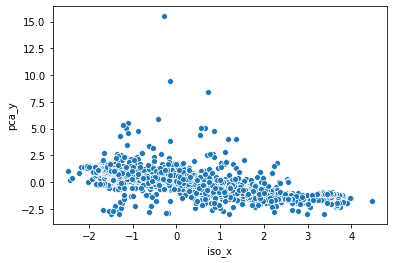

,iso_x,pca_y,C9A
iso_x,1.00000,-0.68452,-0.68452
pca_y,-0.68452,1.00000,1.00000
C9A,-0.68452,1.00000,1.00000


In [11]:
sns.scatterplot(x='iso_x',y='pca_y',data=train)
plt.show()
train.corr().loc[['iso_x','pca_y',y_name],['iso_x','pca_y',y_name]]

# modeling

評分指標

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=['score'])

In [13]:
import xgboost
from sklearn.svm import SVR
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings 
warnings.simplefilter('ignore')

#選擇模型
#model = DecisionTreeRegressor(max_depth=1)
#model = xgboost.XGBRegressor(objective='reg:squarederror')
model = SVR()
#model = LinearRegression()

#交叉驗證
val_scores = cross_validate(model,train[['iso_x']],train['pca_y'],cv=5)

#交叉驗證結果
print('交叉驗證分數:',val_scores['test_score'])
print('交叉驗證平均分數:',val_scores['test_score'].mean())

交叉驗證分數: [0.7015944  0.23182358 0.43735832 0.31251373 0.48624498]
交叉驗證平均分數: 0.4339070024126981


# fit & predict

In [0]:
# fit 
model.fit(train[['iso_x']],train['pca_y'])
# predict
train['y_pred'] = model.predict(train[['iso_x']])
test_170['y_pred'] = model.predict(test_170[['iso_x']])
test_50['y_pred'] = model.predict(test_50[['iso_x']])

# plot

data for plot

In [0]:
by_col = 'iso_x'
train_sample_point = train.sample(1000).sort_values(by = by_col)
test_170_point = test_170.sort_values(by = by_col)
test_50_point = test_50.sort_values(by = by_col)

plot function

In [0]:
def pred_plot(df,by_col):
  fig = plt.figure(figsize=(20,5))
  plt.plot(df[by_col],df['y_pred'],label='pred line',color='red')
  plt.scatter(df[by_col],df['pca_y'],label='data point')
  plt.xlabel(by_col)
  plt.ylabel('pca_y')
  plt.legend()
  plt.show()

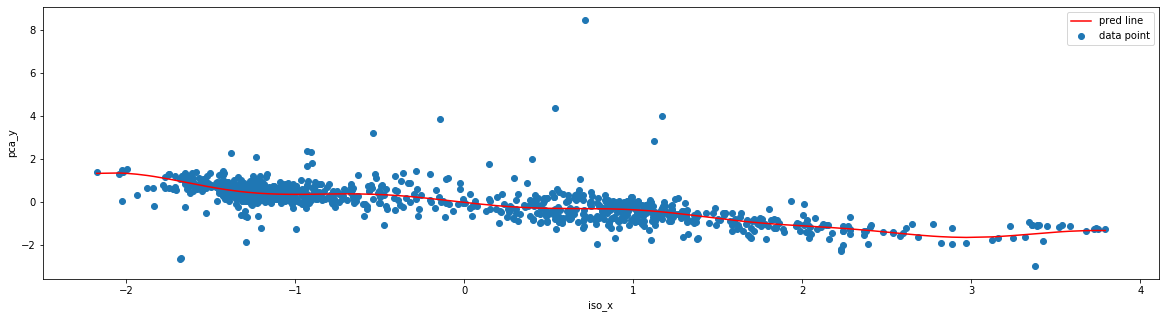

train_scores:


,R2,RMSE,mean_absolute_error
score,0.481697,0.63929,0.354368


In [17]:
pred_plot(train_sample_point,by_col)
plt.show()
print('train_scores:')
metric(train['pca_y'],train['y_pred'])

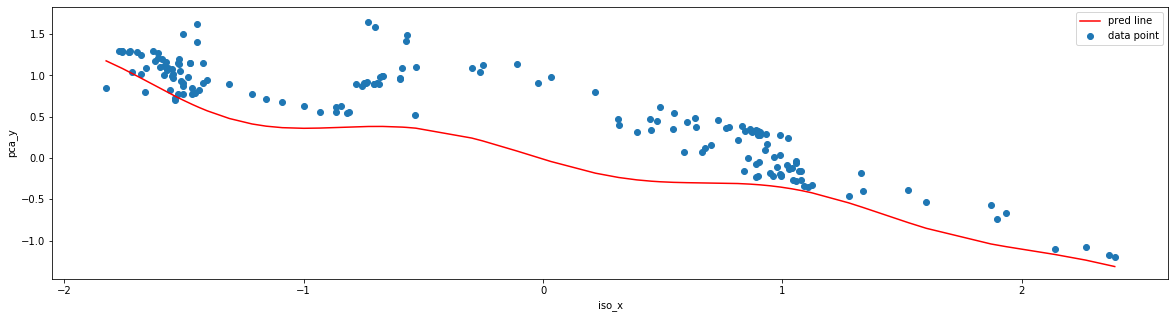

test_170_scores:


,R2,RMSE,mean_absolute_error
score,0.331857,0.495309,0.416872


In [18]:
pred_plot(test_170_point,by_col)
plt.show()
print('test_170_scores:')
metric(test_170['pca_y'],test_170['y_pred'])

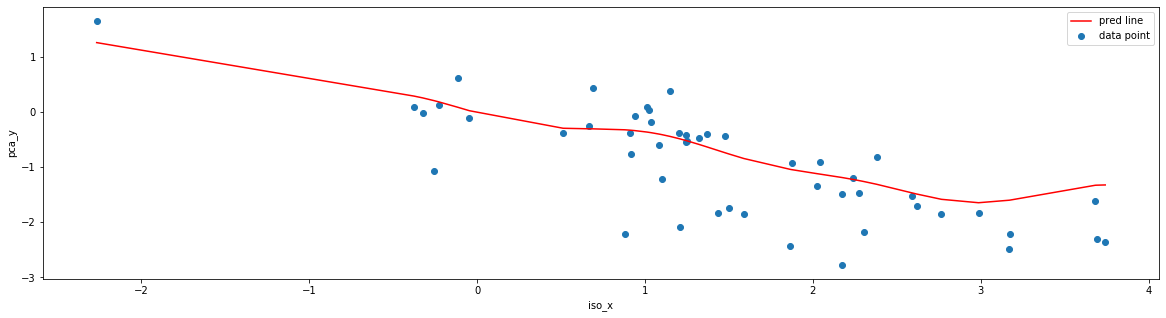

test_50_scores:


,R2,RMSE,mean_absolute_error
score,0.496912,0.686437,0.497377


In [19]:
pred_plot(test_50_point,by_col)
plt.show()
print('test_50_scores:')
metric(test_50['pca_y'],test_50['y_pred'])

# 預測表現(還原)

In [20]:
train_pred_all = pd.DataFrame(pca.inverse_transform(train[['y_pred']]),columns=pca_col)
res = pd.DataFrame()
for col in pca_col:
  res = res.append(metric(train[col],train_pred_all[col]))
res.index = pca_col
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C9A,0.481697,0.63929,0.354368
AVG,0.481697,0.63929,0.354368


In [21]:
test_170_pred_all = pd.DataFrame(pca.inverse_transform(test_170[['y_pred']]),columns=pca_col)
res = pd.DataFrame()
for col in pca_col:
  res = res.append(metric(test_170[col],test_170_pred_all[col]))
res.index = pca_col
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C9A,0.331857,0.495309,0.416872
AVG,0.331857,0.495309,0.416872


In [22]:
test_50_pred_all = pd.DataFrame(pca.inverse_transform(test_50[['y_pred']]),columns=pca_col)
res = pd.DataFrame()
for col in pca_col:
  res = res.append(metric(test_50[col],test_50_pred_all[col]))
res.index = pca_col
res.loc['AVG'] = res.mean()
res

,R2,RMSE,mean_absolute_error
C9A,0.496912,0.686437,0.497377
AVG,0.496912,0.686437,0.497377


# check outliers

In [23]:
loss = (test_170_point['pca_y'] - test_170_point['y_pred'])**2 # 平方誤差
loss = loss.sort_values(ascending=False)
test_170_point['out'] = False
test_170_point.loc[loss.head(5).index,'out'] = True
print(loss.head(5))

48    1.603037
47    1.462437
36    1.255072
35    1.100143
37    1.083767
dtype: float64


In [24]:
loss = (test_50_point['pca_y'] - test_50_point['y_pred'])**2 # 平方誤差
loss = loss.sort_values(ascending=False)
test_50_point['out'] = False
test_50_point.loc[loss.head(5).index,'out'] = True
print(loss.head(5))

5      3.599609
150    2.553476
55     2.502765
0      1.959203
35     1.616193
dtype: float64


# plot out

In [0]:
def d_out_score(df):
  df = df.loc[df['out'] == False]
  return metric(df['pca_y'],df['y_pred'])

In [0]:
def d_out_all_score(df):
  df = df.loc[df['out'] == False]
  df_pred_all = pd.DataFrame(pca.inverse_transform(df[['y_pred']]),columns=pca_col)
  res = pd.DataFrame()
  for col in pca_col:
    res = res.append(metric(df[col],df_pred_all[col]))
  res.index = pca_col
  res.loc['AVG'] = res.mean()
  return res

In [0]:
def plot_out(df):
  fig = plt.figure(figsize=(20,5))
  out_point = df[df['out'] == True]
  plt.plot(df[by_col],df['y_pred'],label='pred line',color='red')
  plt.scatter(df[by_col],df['pca_y'],label='test point')
  plt.scatter(out_point[by_col],out_point['pca_y'],label='out point',color='orange')
  plt.xlabel(by_col)
  plt.ylabel('pca_y')
  plt.legend()
  plt.show()

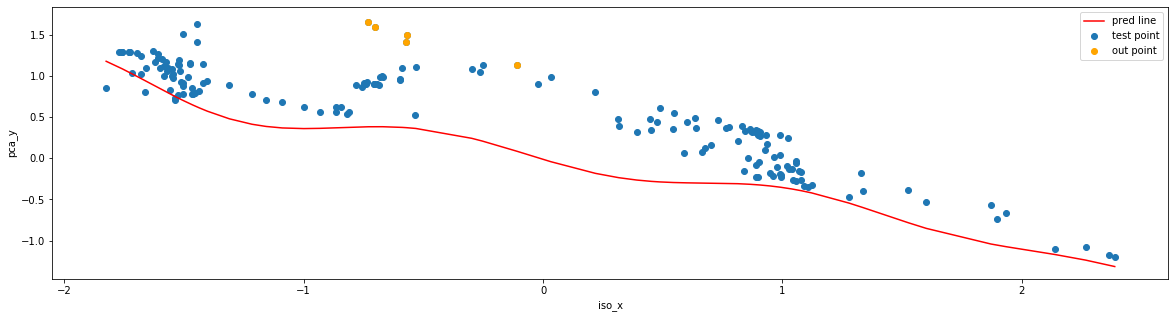

,R2,RMSE,mean_absolute_error
score,0.393879,0.461892,0.395046


In [28]:
plot_out(test_170_point)
plt.show()
d_out_score(test_170_point)

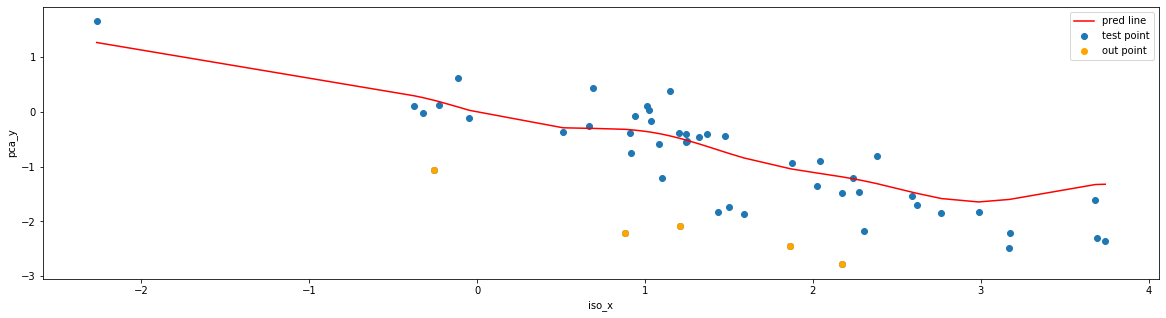

,R2,RMSE,mean_absolute_error
score,0.699897,0.501743,0.380458


In [29]:
plot_out(test_50_point)
plt.show()
d_out_score(test_50_point)

# drop out all score

In [30]:
d_out_all_score(test_170_point)

,R2,RMSE,mean_absolute_error
C9A,0.393879,0.461892,0.395046
AVG,0.393879,0.461892,0.395046


In [31]:
d_out_all_score(test_50_point)

,R2,RMSE,mean_absolute_error
C9A,0.699897,0.501743,0.380458
AVG,0.699897,0.501743,0.380458
